In [2]:
import tensorflow as tf
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt

In [71]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [9]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
len(dataset)

68

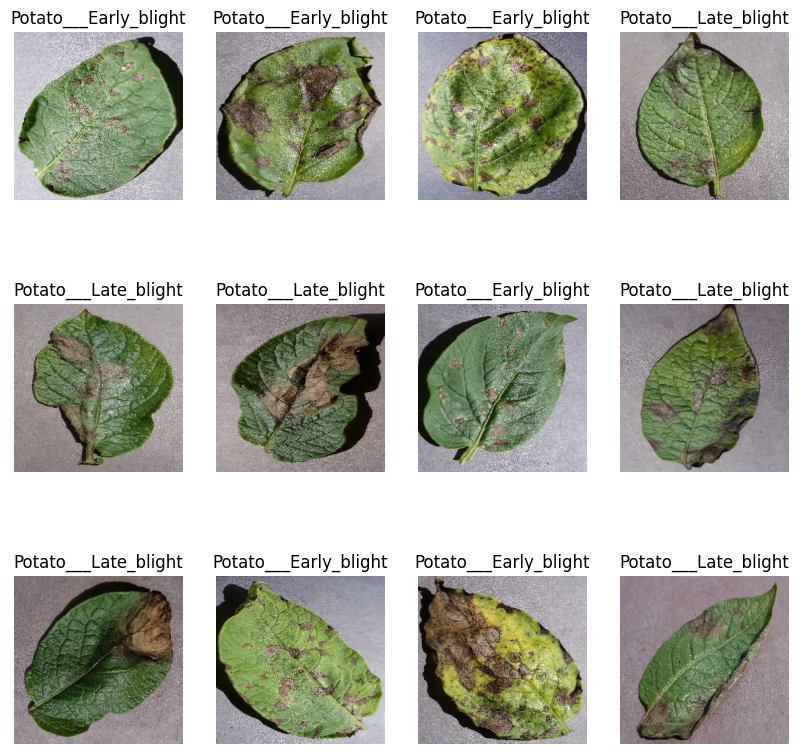

In [37]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.axis("off")
        plt.title(class_names[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype('uint8'))

In [30]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Preparing training , testing and validation data

In [49]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [50]:
train_ds = dataset.take(54)
len(train_ds)

54

In [51]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [52]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [53]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [54]:
test_ds = test_ds.skip(6)
len(test_ds)

8

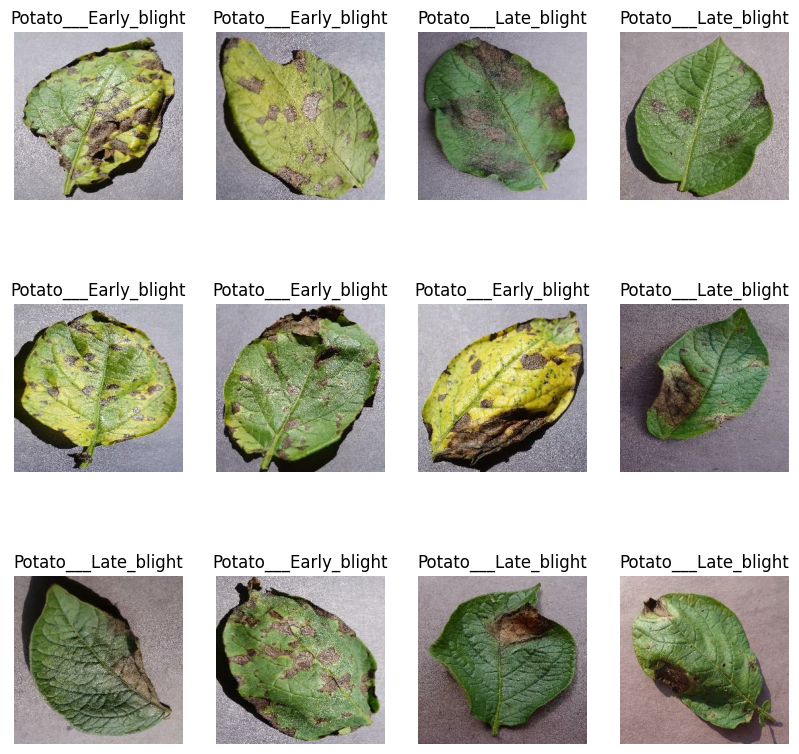

In [55]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.axis("off")
        plt.title(class_names[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype('uint8'))

In [56]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [57]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [58]:
len(train_ds)

54

In [59]:
len(val_ds)

6

In [61]:
len(test_ds)

8

In [62]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [63]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [64]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [73]:
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
no_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64 , activation='relu'),
    layers.Dense(no_classes , activation='softmax')
])

model.build(input_shape=input_shape)

In [74]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [75]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [76]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
54/54 [==============================] - 228s 4s/step - loss: 0.9061 - accuracy: 0.5087 - val_loss: 0.8512 - val_accuracy: 0.6875
Epoch 2/10
54/54 [==============================] - 224s 4s/step - loss: 0.6790 - accuracy: 0.7176 - val_loss: 0.8984 - val_accuracy: 0.6250
Epoch 3/10
54/54 [==============================] - 216s 4s/step - loss: 0.3486 - accuracy: 0.8536 - val_loss: 0.2632 - val_accuracy: 0.8854
Epoch 4/10
54/54 [==============================] - 223s 4s/step - loss: 0.2777 - accuracy: 0.8883 - val_loss: 0.1980 - val_accuracy: 0.9375
Epoch 5/10
54/54 [==============================] - 273s 5s/step - loss: 0.2947 - accuracy: 0.8854 - val_loss: 0.2786 - val_accuracy: 0.8958
Epoch 6/10
54/54 [==============================] - 245s 5s/step - loss: 0.2123 - accuracy: 0.9161 - val_loss: 0.1238 - val_accuracy: 0.9583
Epoch 7/10
54/54 [==============================] - 219s 4s/step - loss: 0.1904 - accuracy: 0.9329 - val_loss: 0.1459 - val_accuracy: 0.9167
Epoch 8/10
54

In [80]:
score = model.evaluate(test_ds)

8/8 [==============================] - 24s 1s/step - loss: 0.1193 - accuracy: 0.9570


In [81]:
score

[0.11927739530801773, 0.95703125]

In [84]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [85]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [88]:
history.history['val_accuracy']

[0.6875,
 0.625,
 0.8854166865348816,
 0.9375,
 0.8958333134651184,
 0.9583333134651184,
 0.9166666865348816,
 0.9375,
 0.953125,
 0.9739583134651184]

In [89]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

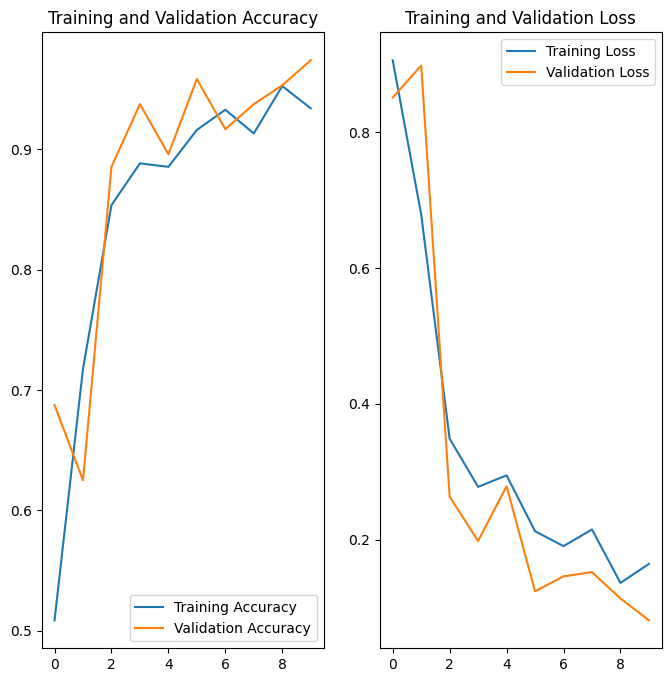

In [93]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [97]:
import numpy as np

Image to predict
Label Potato___Early_blight
1/1 [==============================] - 1s 1s/step
Predicted Label:  Potato___Early_blight
99.99


Image to predict
Label Potato___Early_blight
1/1 [==============================] - 1s 1s/step
Predicted Label:  Potato___Early_blight
99.99


Image to predict
Label Potato___Early_blight
1/1 [==============================] - 1s 1s/step
Predicted Label:  Potato___Early_blight
99.91




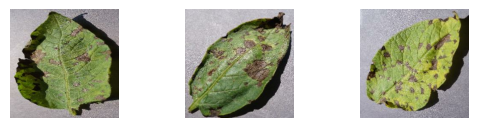

In [107]:
for image_batch,label_batch in test_ds.take(1):
    for i in range(3): 
        first_image = image_batch[i].numpy().astype('uint8')
        first_label = label_batch[i].numpy()

        print("Image to predict")
        plt.subplot(3,3,i+1)
        plt.axis('off')
        plt.imshow(first_image)
        print("Label",class_names[first_label])

        predicted_batch = model.predict(image_batch)
        print("Predicted Label: ",class_names[np.argmax(predicted_batch[i])])

        confidence = round(100*np.max(predicted_batch[i]) ,2)
        print(confidence)
        print("")
        print("")

In [108]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


In [109]:
model.save("../potatoes.h5")

C:\Users\DELL PC\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
